In [1]:
#image size resize to 240*240
#https://iutbox.iut.ac.ir/index.php/s/SRa8PwBoxEY4ZMf
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib 
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time


INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load the dataset
print("[INFO] loading the dataset...")


transform = transforms.Compose([
    transforms.Resize((240, 240)),
    #for solving overfitting
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainData = datasets.ImageFolder(root=r"E:\University\ComputatinalIntelligance\HomeWork\2\HW02-Practical\Dataset\train", transform=transform)

valData = datasets.ImageFolder(root=r"E:\University\ComputatinalIntelligance\HomeWork\2\HW02-Practical\Dataset\valid", transform=transform)
    
testData = datasets.ImageFolder(root=r"E:\University\ComputatinalIntelligance\HomeWork\2\HW02-Practical\Dataset\test", transform=transform)

print(len(trainData))
print(len(valData))

[INFO] loading the dataset...
15000
5000


In [3]:
# initialize the train, validation, and test data loaders

trainDataLoader = DataLoader(trainData, shuffle=True,
    batch_size=BATCH_SIZE)

valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE






In [4]:
#underfit model


#class My_Model(Module):
#    def __init__(self, numChannels, classes):
        
#        super(My_Model, self).__init__()
#        self.fc1 = Linear(in_features=numChannels * 240* 240, out_features=classes) # deleted all layers except one linear layer
#        self.logSoftmax =LogSoftmax(dim=1)
        
#    def forward(self, x):
#            x = flatten(x, 1) # deleted all layers except one flatten layer
#            x = self.fc1(x)
#            output = self.logSoftmax(x)
#            return output




In [5]:
 #overfite model
class My_Model(Module):
     def __init__(self, numChannels, classes):
        
        
     
         super(My_Model, self).__init__()
          
         self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
             kernel_size=(7, 7), stride=(2, 2), padding=3)
         self.relu1 = ReLU()
         self.maxpool1 = MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        
         self.conv2 = Conv2d(in_channels=20, out_channels=50,
             kernel_size=(5, 5), padding=2)
         self.relu2 = ReLU()
         self.maxpool2 = MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        
         self.fc1 = Linear(in_features=50 * 30 * 30, out_features=500)
         self.relu3 = ReLU()
       
         self.fc2 = Linear(in_features=500, out_features=classes)
         self.logSoftmax =LogSoftmax(dim=1)


     def forward(self, x):
      
         x = self.conv1(x)
         x = self.relu1(x)
         x = self.maxpool1(x)
        
         x = self.conv2(x)
         x = self.relu2(x)
         x = self.maxpool2(x)
      
         x = flatten(x, 1)
         x = self.fc1(x)
         x = self.relu3(x)
        
         x = self.fc2(x)
         output = self.logSoftmax(x)
        
         return output


In [6]:

print("[INFO] initializing the My_Model model...")


#GRID SEARCH 



#initial learning rate

param_grid = {

    'lr': [ 0.001 ]
}



# param_grid = {

#     'lr': [ 0.00001,0.0001,0.001,0.01,0.1 ]
# }



#bestfit model learning rate
#param_grid = {

#    'lr': [ 0.0008 ]
#}





model = My_Model(
    numChannels=3,
    classes=len(trainData.classes)).to(device)


for i in range(1):

    
    opt = Adam(model.parameters(), lr=param_grid["lr"][i])

    lossFn = nn.NLLLoss()
   
    H = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
   
    print("[INFO] training the network...")
    startTime = time.time()

    # loop over our epochs
    for e in range(0, EPOCHS):
        print('epoch:' ,e+1)
      
        model.train()
     
        totalTrainLoss = 0
        totalValLoss = 0
       
        trainCorrect = 0
        valCorrect = 0
        # loop over the training set
        for (x, y) in trainDataLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # perform a forward pass and calculate the training loss
            pred = model(x)
            loss = lossFn(pred, y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += loss
            trainCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
        # switch off autograd for evaluation
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            # loop over the validation set
            for (x, y) in valDataLoader:
                # send the input to the device
                (x, y) = (x.to(device), y.to(device))
                # make the predictions and calculate the validation loss
                pred = model(x)
                totalValLoss += lossFn(pred, y)
                # calculate the number of correct predictions
                valCorrect += (pred.argmax(1) == y).type(
                    torch.float).sum().item()
                avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        # calculate the training and validation accuracy
        trainCorrect = trainCorrect / len(trainDataLoader.dataset)
        valCorrect = valCorrect / len(valDataLoader.dataset)
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["train_acc"].append(trainCorrect)
        H["val_loss"].append(avgValLoss.cpu().detach().numpy())
        H["val_acc"].append(valCorrect)
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
            avgTrainLoss, trainCorrect))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
            avgValLoss, valCorrect))

[INFO] initializing the My_Model model...
[INFO] training the network...
epoch: 1
[INFO] EPOCH: 1/10
Train loss: 1.165394, Train accuracy: 0.5268
Val loss: 0.876018, Val accuracy: 0.6778

epoch: 2
[INFO] EPOCH: 2/10
Train loss: 0.719053, Train accuracy: 0.7307
Val loss: 0.715711, Val accuracy: 0.7450

epoch: 3
[INFO] EPOCH: 3/10
Train loss: 0.557337, Train accuracy: 0.7955
Val loss: 0.691126, Val accuracy: 0.7642

epoch: 4
[INFO] EPOCH: 4/10
Train loss: 0.458592, Train accuracy: 0.8357
Val loss: 0.593298, Val accuracy: 0.8078

epoch: 5
[INFO] EPOCH: 5/10
Train loss: 0.386877, Train accuracy: 0.8617
Val loss: 0.563577, Val accuracy: 0.8124

epoch: 6
[INFO] EPOCH: 6/10
Train loss: 0.322932, Train accuracy: 0.8850
Val loss: 0.573917, Val accuracy: 0.8206

epoch: 7
[INFO] EPOCH: 7/10
Train loss: 0.275835, Train accuracy: 0.9091
Val loss: 0.632081, Val accuracy: 0.8160

epoch: 8
[INFO] EPOCH: 8/10
Train loss: 0.238937, Train accuracy: 0.9207
Val loss: 0.624564, Val accuracy: 0.8226

epoch: 

In [7]:
correct = 0
total = 0

with torch.no_grad():
    for data in testDataLoader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))


import csv

predictions = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for data in testDataLoader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted labels to the list
        predictions.extend(predicted.cpu().numpy().tolist())

# Write the predicted labels to a CSV file
with open('predictions_overfit.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageId', 'Label'])
    for i, label in enumerate(predictions):
        writer.writerow([i+1, label])




from sklearn.metrics import f1_score
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for data in testDataLoader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    f1 = f1_score(true_labels, predicted_labels,average='weighted')

print('F1 score of the network on test images:', f1)



Accuracy of the network on test images: 81 %
F1 score of the network on test images: 0.8127076813822343


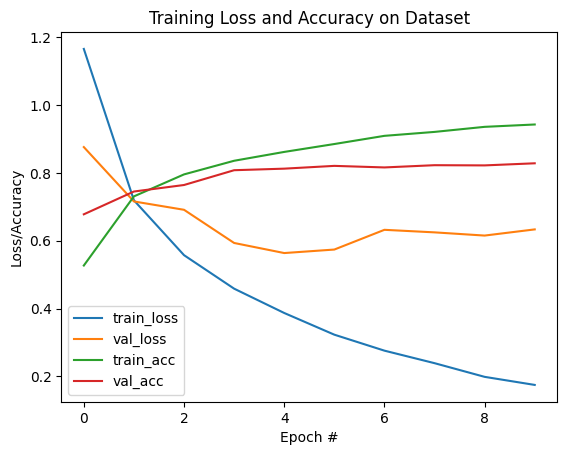

In [8]:
# plot the training loss and accuracy
# plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()